In [1]:
from pathlib import Path
import random

from utils import compare_metadata, generate_plots
from librep.datasets.har import loaders

from librep.datasets.har.loaders import PandasMultiModalLoader, KuHar_BalancedView20HzMotionSenseEquivalent


/home/patrick/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
standartized_codes = {
    0: "sit",
    1: "stand",
    2: "walk",
    3: "stair up",
    4: "stair down",
    5: "run",
    6: "stair up and down"
}

In [3]:
raw_view_path = Path("../data/processed/MotionSense/raw_balanced")
processed_view_path = Path("../data/processed/MotionSense/standartized_balanced")

train_raw, validation_raw, test_raw = PandasMultiModalLoader(raw_view_path).load(
    label="standard activity code"
)
train_processed, validation_processed, test_processed = PandasMultiModalLoader(
    processed_view_path
).load(label="standard activity code")


In [4]:
compare_metadata(
    train_raw.data,
    train_processed.data,
    ["activity code", "user", "standard activity code", "index"],
)


Columns 'user' are not equal


False

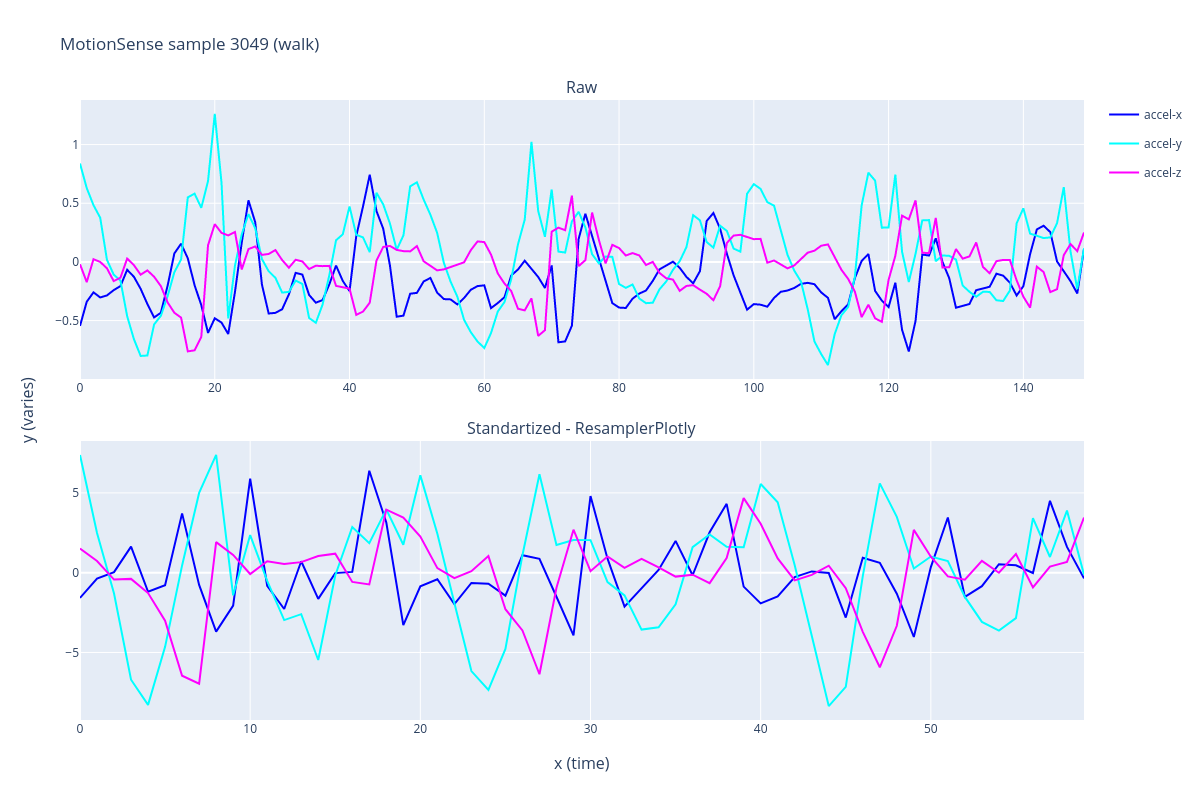

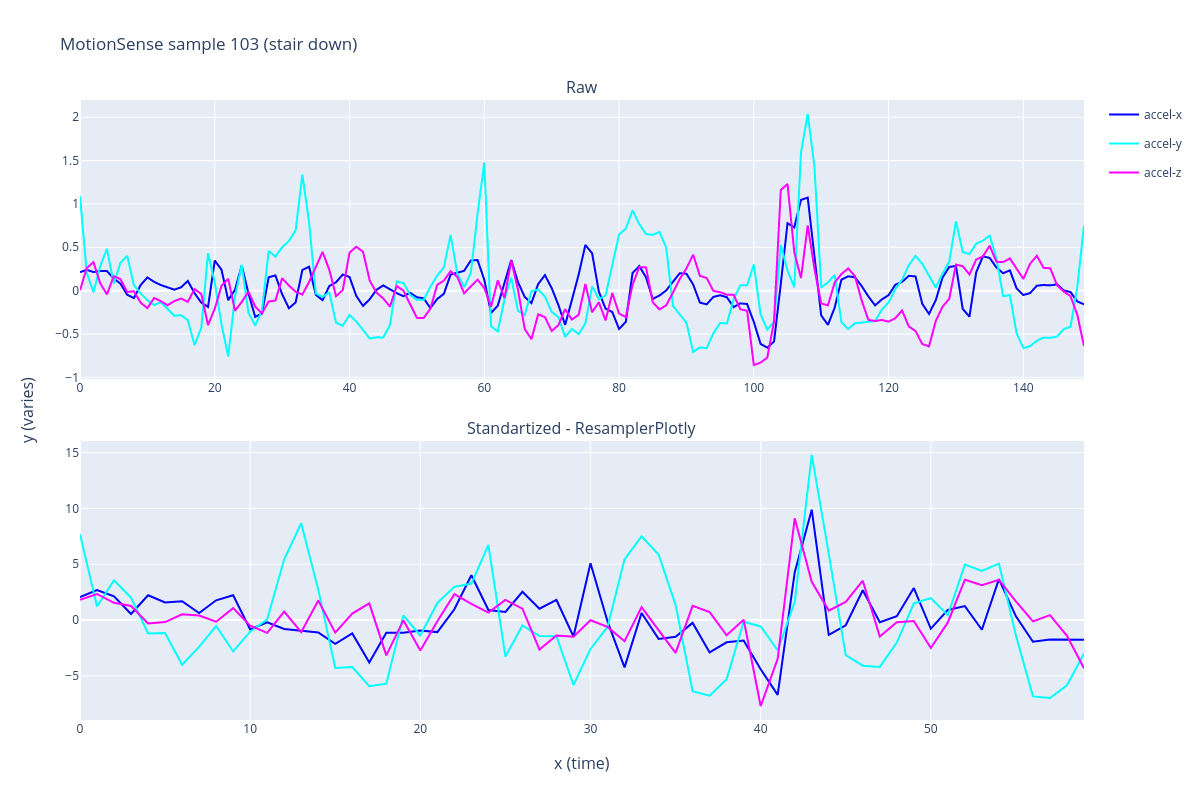

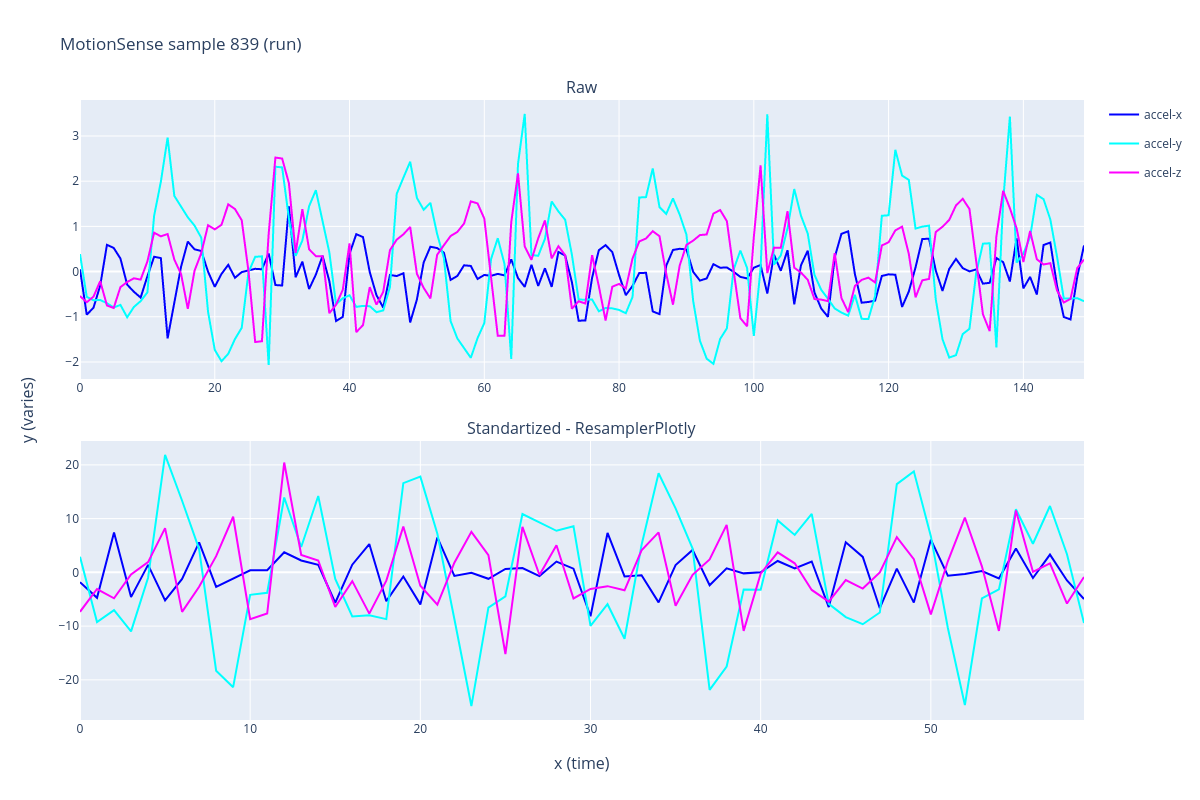

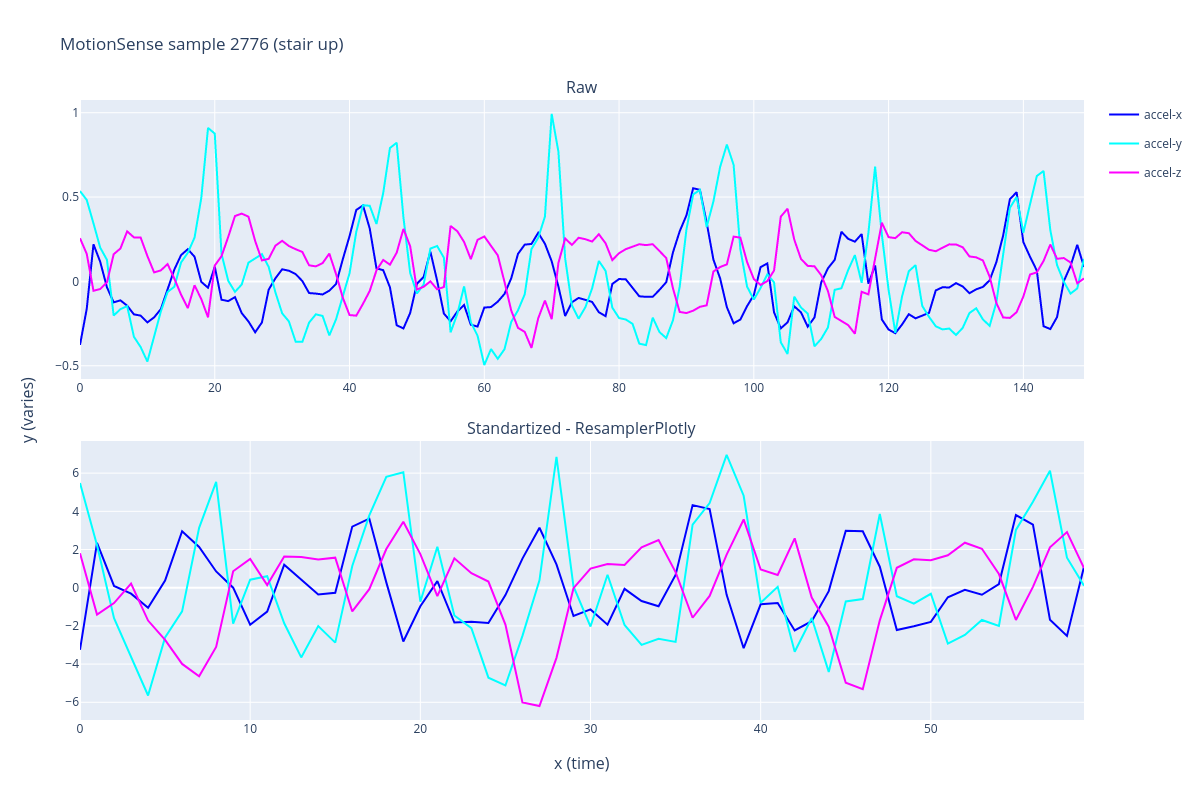

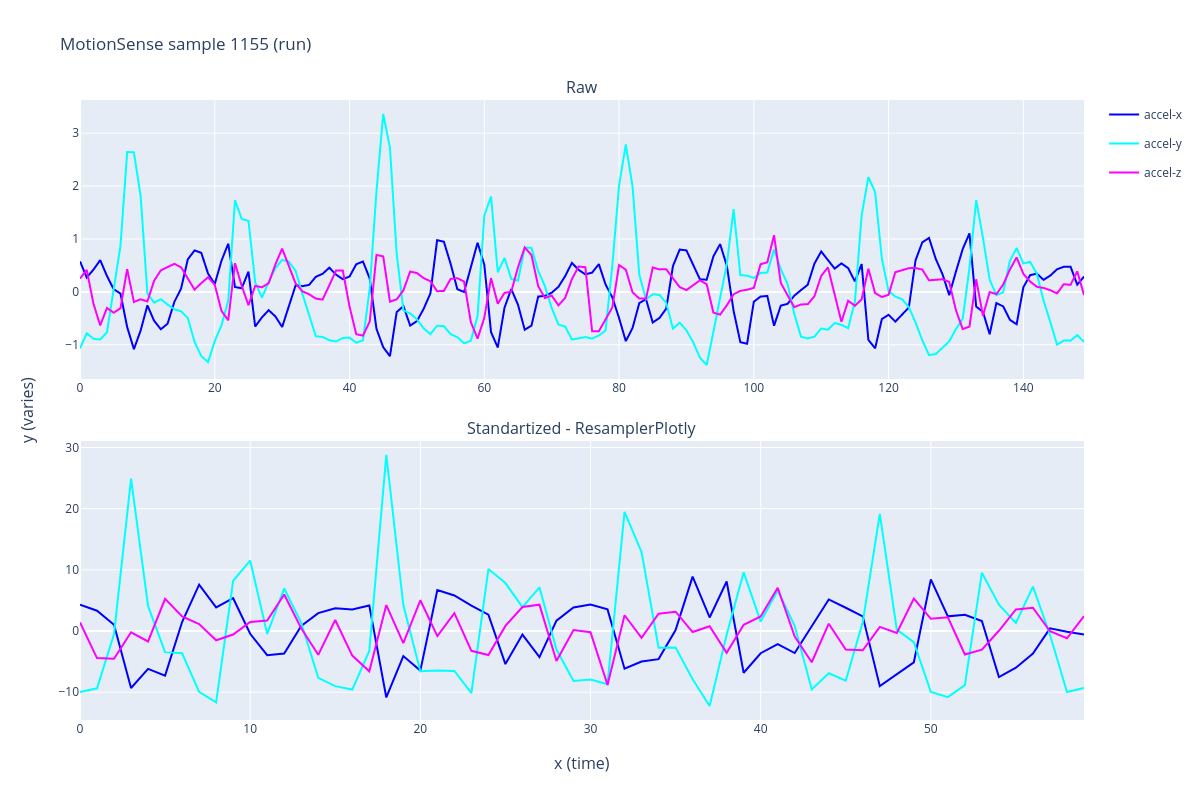

In [5]:
selected_samples = random.sample(range(len(train_raw)), 5)

for i in selected_samples:
    label = standartized_codes[train_raw[i][1]]

    fig = generate_plots(
        train_raw,
        train_processed,
        sample_no=i,
        windows=["accel-x", "accel-y", "accel-z"],
        height=800,
        width=1200,
        names=["Raw", "Standartized - ResamplerPlotly"],
        vertical_spacing=0.1,
        title=f"MotionSense sample {i} ({label})",
        x_title="x (time)",
        y_title="y (varies)",
    )
    fig.show("png")


In [6]:
from librep.transforms.fft import FFT
from librep.datasets.multimodal.operations import DatasetWindowedTransform

transformer = DatasetWindowedTransform(transform=FFT(centered=True), do_fit=False, new_suffix=".fft")
fft_train_raw, fft_validation_raw, fft_test_raw = transformer(train_raw), transformer(validation_raw), transformer(test_raw)
fft_train_processed, fft_validation_processed, fft_test_processed = transformer(train_processed), transformer(validation_processed), transformer(test_processed)

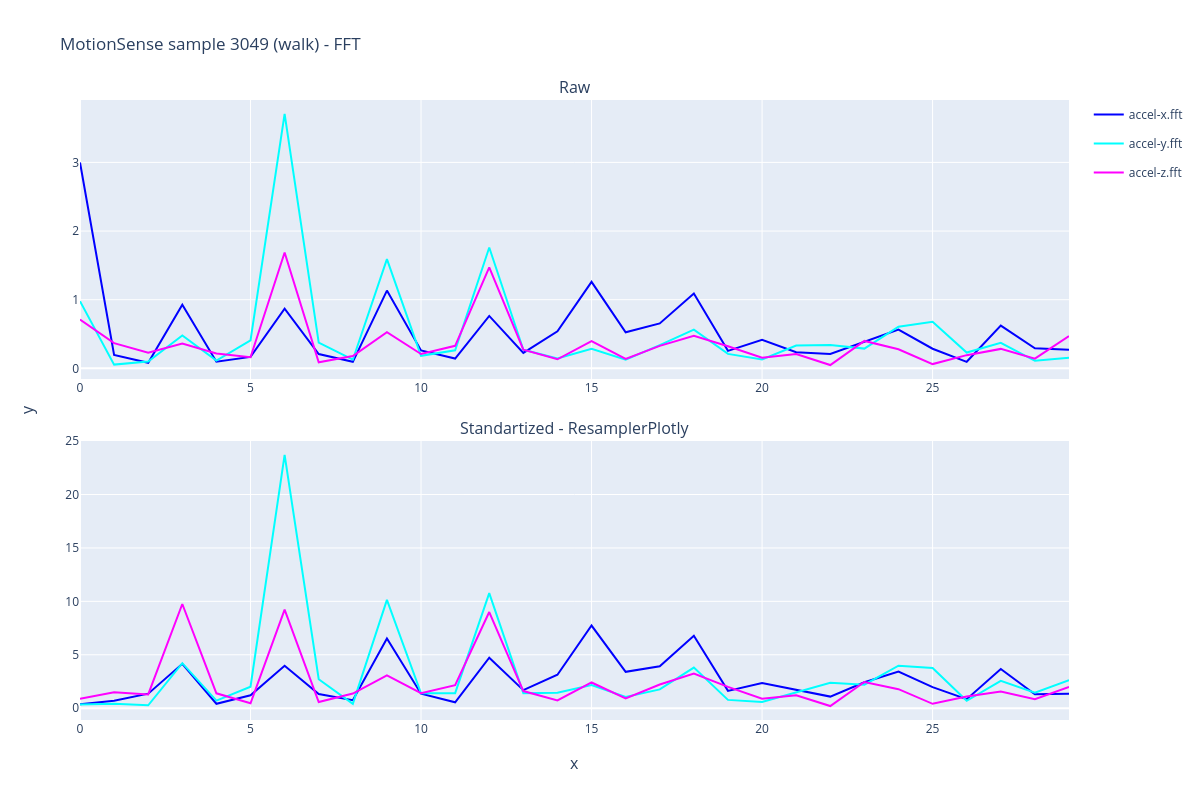

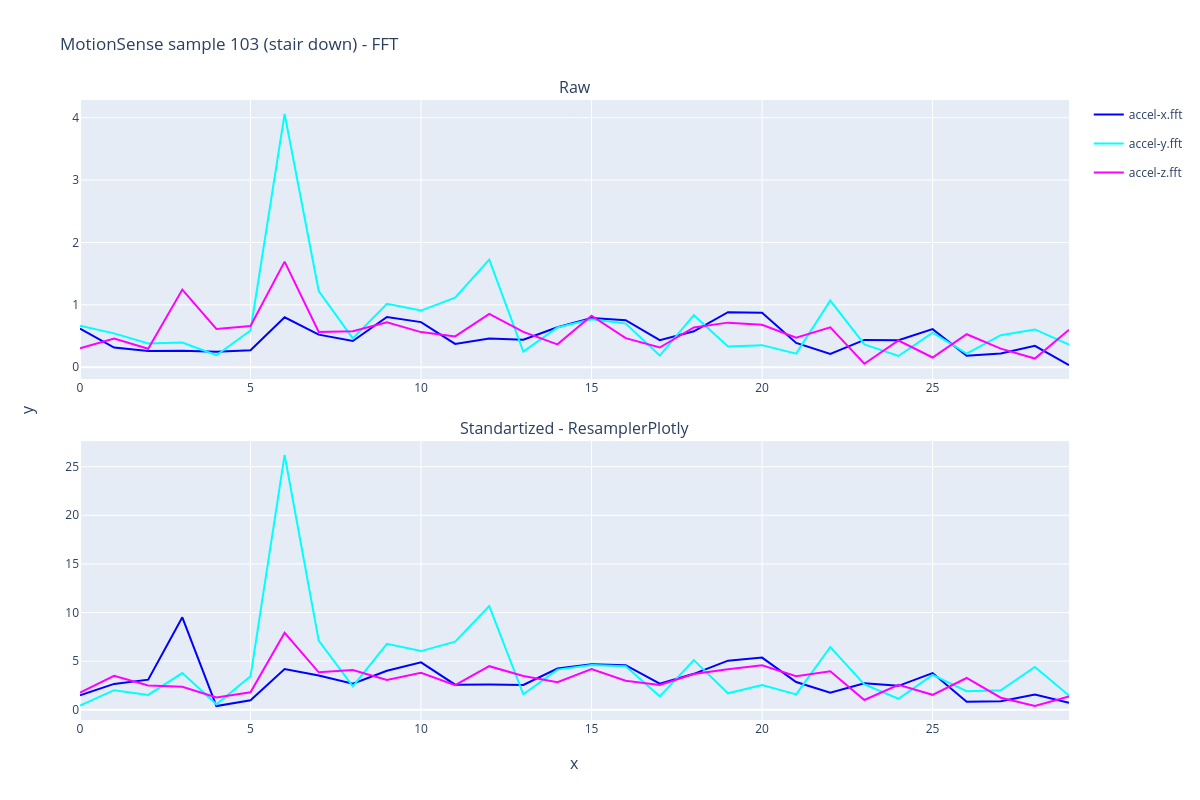

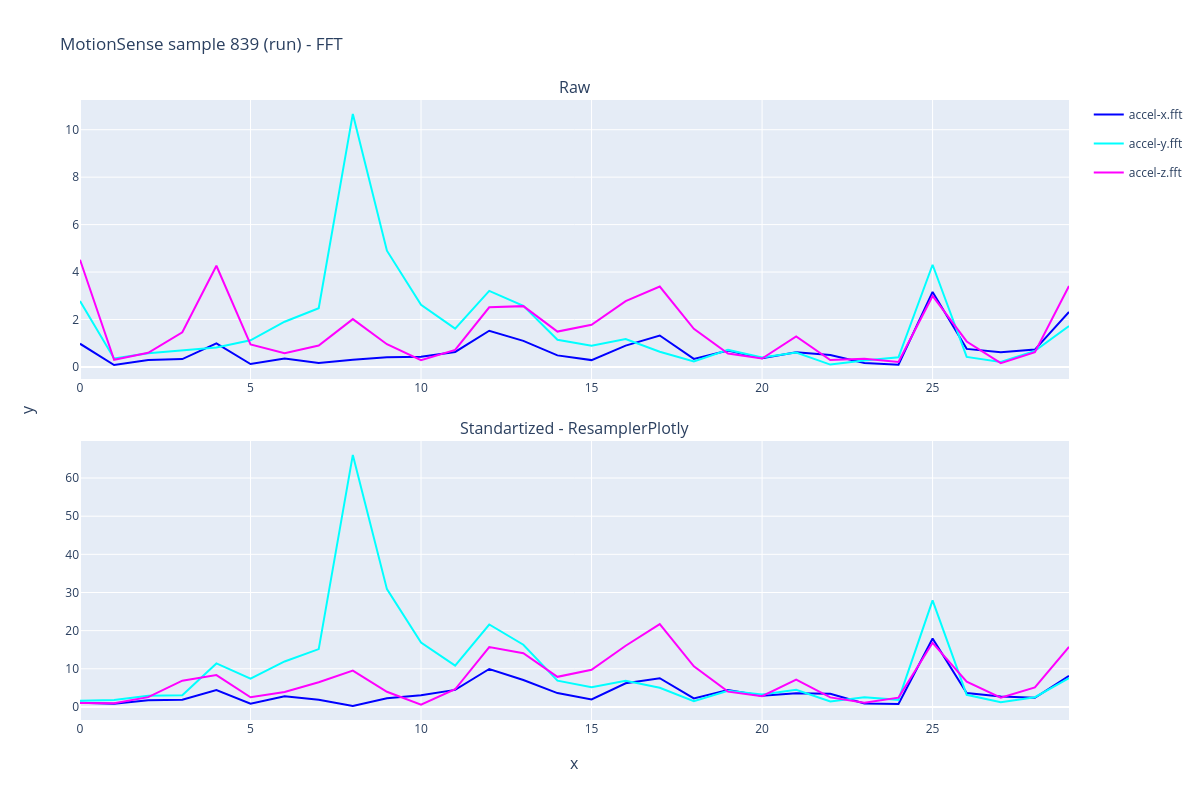

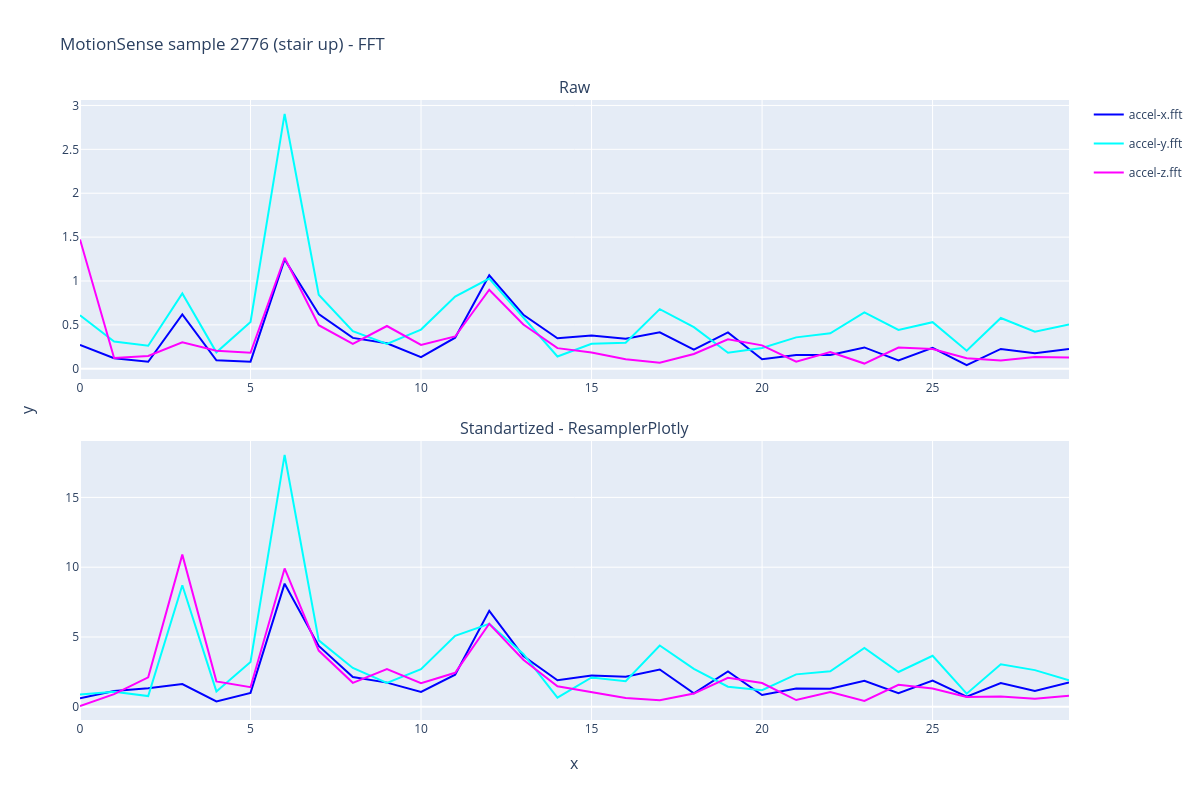

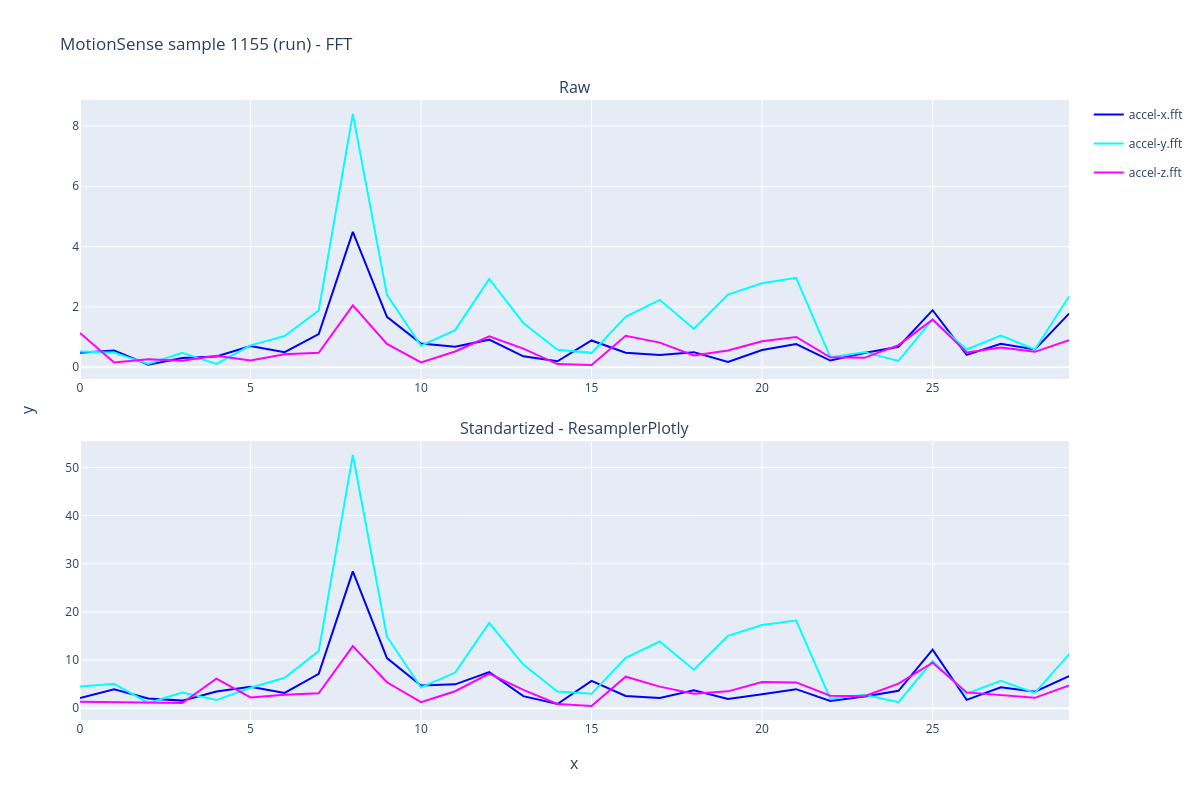

In [7]:
for i in selected_samples:
    label = standartized_codes[train_raw[i][1]]

    fig = generate_plots(
        fft_train_raw,
        fft_train_processed,
        sample_no=i,
        windows=["accel-x.fft", "accel-y.fft", "accel-z.fft"],
        height=800,
        width=1200,
        names=["Raw", "Standartized - ResamplerPlotly"],
        vertical_spacing=0.1,
        title=f"MotionSense sample {i} ({label}) - FFT",
        x_title="x",
        y_title="y",
        the_slice=slice(0, 30, 1)
    )
    fig.show("png")

In [8]:
from sklearn.ensemble import RandomForestClassifier
from umap import UMAP
from librep.datasets.multimodal.operations import (
    DatasetFitter,
    DatasetPredicter,
    DatasetWindowedTransform,
    DatasetY,
    DatasetEvaluator,
    DatasetTransformer,
)
from librep.metrics.report import ClassificationReport


def train_rf(train_dset, test_dset, use_umap=False):
    if use_umap:
        umap_model = UMAP(n_neighbors=5, n_components=5, metric="euclidean")
        DatasetFitter(umap_model, use_y=False)(train_dset)
        train_dset = DatasetTransformer(umap_model)(train_dset)
        test_dset = DatasetTransformer(umap_model)(test_dset)
    
    model = RandomForestClassifier()
    DatasetFitter(model, use_y=True)(train_dset)
    y_pred = DatasetPredicter(model)(test_dset)
    y_true = DatasetY()(test_dset)
    return DatasetEvaluator(ClassificationReport(normalize="all"))(y_true, y_pred)


# Classification without dimension reduction

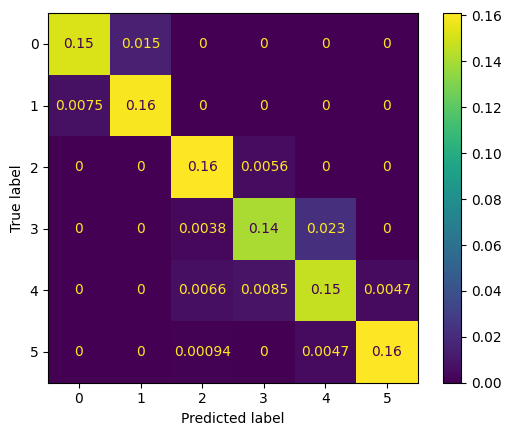

{'accuracy': 0.9199623352165726, 'f1 score (weighted)': 0.9198257948024733, 'f1 score (micro)': 0.9199623352165724, 'f1 score (macro)': 0.9198257948024734, 'confusion matrix': [[161, 16, 0, 0, 0, 0], [8, 169, 0, 0, 0, 0], [0, 0, 171, 6, 0, 0], [0, 0, 4, 149, 24, 0], [0, 0, 7, 9, 156, 5], [0, 0, 1, 0, 5, 171]]}


In [9]:
fft_train_validation_raw = fft_train_raw.concatenate(fft_validation_raw)
result = train_rf(fft_train_validation_raw, fft_test_raw)
print(result)

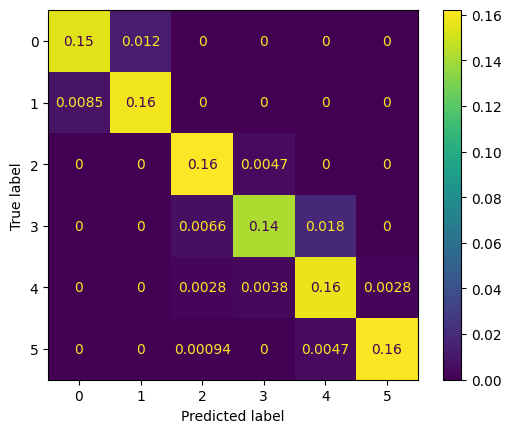

{'accuracy': 0.9350282485875706, 'f1 score (weighted)': 0.9348926669962503, 'f1 score (micro)': 0.9350282485875706, 'f1 score (macro)': 0.9348926669962504, 'confusion matrix': [[164, 13, 0, 0, 0, 0], [9, 168, 0, 0, 0, 0], [0, 0, 172, 5, 0, 0], [0, 0, 7, 151, 19, 0], [0, 0, 3, 4, 167, 3], [0, 0, 1, 0, 5, 171]]}


In [10]:
fft_train_validation_processed = fft_train_processed.concatenate(fft_validation_processed)
result = train_rf(fft_train_validation_processed, fft_test_processed)
print(result)

# Classification with dimension reduction

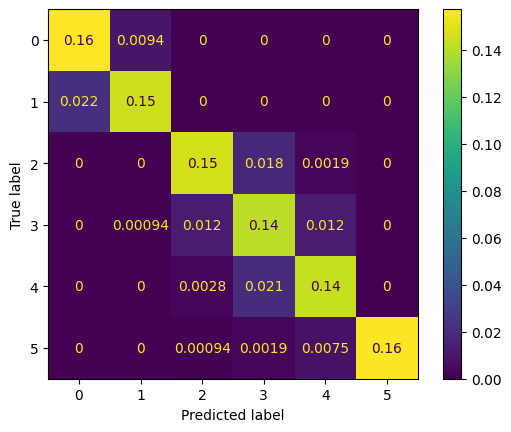

{'accuracy': 0.8898305084745762, 'f1 score (weighted)': 0.8907453857035187, 'f1 score (micro)': 0.8898305084745762, 'f1 score (macro)': 0.8907453857035187, 'confusion matrix': [[167, 10, 0, 0, 0, 0], [23, 154, 0, 0, 0, 0], [0, 0, 156, 19, 2, 0], [0, 1, 13, 150, 13, 0], [0, 0, 3, 22, 152, 0], [0, 0, 1, 2, 8, 166]]}


In [11]:
fft_train_validation_raw = fft_train_raw.concatenate(fft_validation_raw)
result = train_rf(fft_train_validation_raw, fft_test_raw, use_umap=True)
print(result)

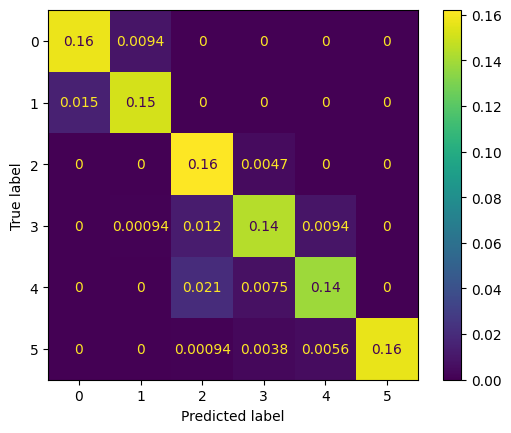

{'accuracy': 0.9096045197740112, 'f1 score (weighted)': 0.9097334443911753, 'f1 score (micro)': 0.9096045197740112, 'f1 score (macro)': 0.9097334443911752, 'confusion matrix': [[167, 10, 0, 0, 0, 0], [16, 161, 0, 0, 0, 0], [0, 0, 172, 5, 0, 0], [0, 1, 13, 153, 10, 0], [0, 0, 22, 8, 147, 0], [0, 0, 1, 4, 6, 166]]}


In [12]:
fft_train_validation_processed = fft_train_processed.concatenate(fft_validation_processed)
result = train_rf(fft_train_validation_processed, fft_test_processed,   use_umap=True)
print(result)